In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pyxdf

In [2]:
WPI_xdf_path = "../HCILab-Group10.xdf"
CSL_xdf_path = "../CSL_Laptop_Group10.xdf"

### View XDF Streams

In [3]:
def view_xdf_streams(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    print(header)

    for stream in data:
        stream_name = stream["info"]["name"][0]
        stream_id = stream["info"]["stream_id"]
        stream_srate = stream["info"]["effective_srate"]
        
        print(f'Stream {stream_name} (Stream ID: {stream_id} with sampling rate {stream_srate})')

In [4]:
view_xdf_streams(WPI_xdf_path)

{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2025-01-10T09:45:10-0500']})}
Stream Unicorn_HCILab1 (Stream ID: 4 with sampling rate 250.3159683662403)
Stream OBS_HCILab1 (Stream ID: 5 with sampling rate 30.000000269745296)
Stream OBS_HCILab2 (Stream ID: 1 with sampling rate 29.059478860026534)
Stream Unicorn_HCILab2 (Stream ID: 3 with sampling rate 228.2440089945108)
Stream OBS_CSL_Laptop (Stream ID: 2 with sampling rate 29.99988491336221)


In [5]:
view_xdf_streams(CSL_xdf_path)

{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2025-01-10T15:45:37+0100']})}
Stream OBS_CSL_Laptop (Stream ID: 1 with sampling rate 30.00000031618321)
Stream Unicorn_CSL_Laptop (Stream ID: 3 with sampling rate 250.27825816624406)
Stream OBS_CSL_LabPC (Stream ID: 4 with sampling rate 60.00047677143859)
Stream Unicorn_HCILab1 (Stream ID: 2 with sampling rate 250.3172102794937)


WPI HCI Lab Streams:
Stream Unicorn_HCILab1 has 1000643 time stamps, starting with 663283.7593286745


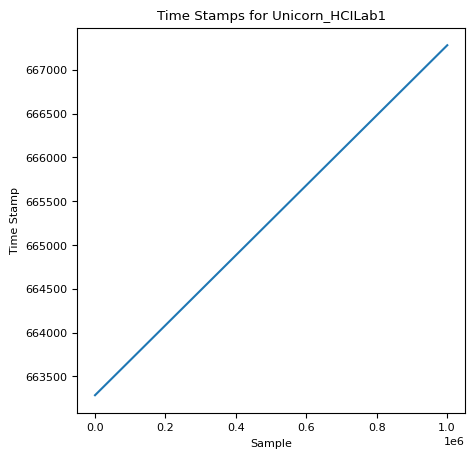

Stream OBS_HCILab1 has 120073 time stamps, starting with 663283.8709504394
Stream OBS_HCILab1 with time series (UNIX) begins with 1736520310.582
Stream OBS_HCILab2 has 116312 time stamps, starting with 663295.6503861432
Stream OBS_HCILab2 with time series (UNIX) begins with 1736520310.013
Stream Unicorn_HCILab2 has 201789 time stamps, starting with 663301.4584387195


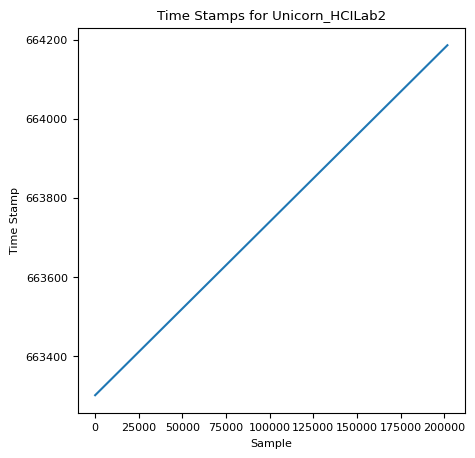

Stream OBS_CSL_Laptop has 120067 time stamps, starting with 663284.0073941177
Stream OBS_CSL_Laptop with time series (UNIX) begins with 1736520322.682

CSL Lab Streams:
Stream OBS_CSL_Laptop has 116818 time stamps, starting with 2423852.469568514
Stream OBS_CSL_Laptop with time series (UNIX) begins with 1736520337.482
Stream Unicorn_CSL_Laptop has 974580 time stamps, starting with 2423852.3116324632


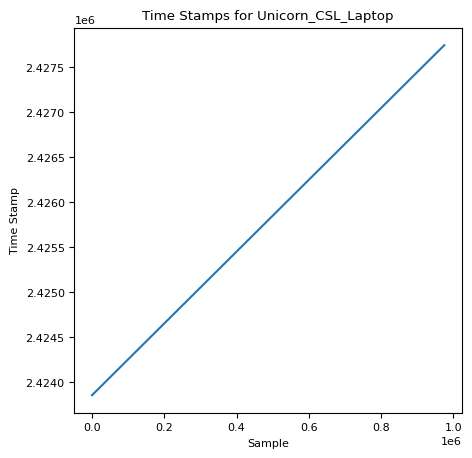

Stream OBS_CSL_LabPC has 233638 time stamps, starting with 2423852.4628338898
Stream OBS_CSL_LabPC with time series (UNIX) begins with 1736520324.918
Stream Unicorn_HCILab1 has 974686 time stamps, starting with 2423852.495222581


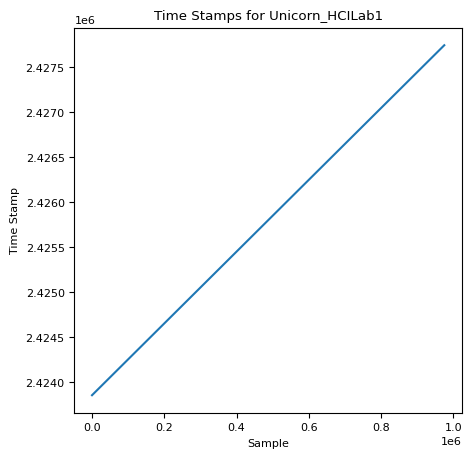

In [6]:
def examine_timestamps_length(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    
    for stream in data:
        stream_name = stream["info"]["name"][0]
        
        time_stamps = stream["time_stamps"]
        
        print(f'Stream {stream_name} has {len(time_stamps)} time stamps, starting with {time_stamps[0]}')
        
        time_series = stream["time_series"]
        if stream_name.startswith("OBS"):
            print(f"Stream {stream_name} with time series (UNIX) begins with {time_series[0][0]}")
        
        if "Unicorn" in stream_name:
            # plot the time stamps
            plt.rc('font', size=8)
            plt.figure(figsize=(5, 5))
            plt.plot(time_stamps)
            plt.xlabel('Sample')
            plt.ylabel('Time Stamp')
            plt.title(f"Time Stamps for {stream_name}")
            plt.show()

# Examine the length of all time stamps in each stream for both XDF files
print("WPI HCI Lab Streams:")
examine_timestamps_length(WPI_xdf_path)

print("\nCSL Lab Streams:")
examine_timestamps_length(CSL_xdf_path)

### Sync Streams!!

In [7]:
def sync_streams(data_streams_1, data_streams_2):
    
    """
    Sync the data by trimming time_stamp and time_series streams so that all EEG and Unicorn Streams begin at the same time
    
    Parameters:
    - data_streams_1: Stream data from WPI HCI Lab xdf file
    - data_streams_2: Stream data from CSL Lab xdf file
    """
    
    # Holds the 8 streams (4 OBS and 4 Unicorn)
    streams = {}
    
    # Create mappings of the 8 stream names to streams
    for stream in data_streams_1:
        stream_name = stream["info"]["name"][0]
        
        if stream_name in ["OBS_HCILab1", "Unicorn_HCILab1", "OBS_HCILab2", "Unicorn_HCILab2"]:
            streams[stream_name] = stream
            
    for stream in data_streams_2:
        stream_name = stream["info"]["name"][0]
        
        if stream_name in ["OBS_CSL_Laptop", "Unicorn_CSL_Laptop", "OBS_CSL_LabPC", "Unicorn_CSL_LabPC"]:
            streams[stream_name] = stream
    
    # From the OBS Video (when Chris says "Begin" and "Time's Up")
    start_unix_timestamp = 1736520530.715
    end_unix_timestamp = 1736524149.315
    duration = end_unix_timestamp - start_unix_timestamp
    frames = 250 * duration
    
    # Trim all the other streams based on the latest Unix timestamp
    for OBS_stream_name, EEG_stream_name in [("OBS_HCILab1", "Unicorn_HCILab1"), ("OBS_HCILab2", "Unicorn_HCILab2"), ("OBS_CSL_Laptop", "Unicorn_CSL_Laptop")]:
        OBS_stream = streams[OBS_stream_name]
        EEG_stream = streams[EEG_stream_name]
        
        # First, find the LabRecorder timestamp in the OBS stream that corresponds to the start and end Unix timestamp
        OBS_unix_times = [ts[0] for ts in OBS_stream["time_series"]]
        start_OBS_index = np.searchsorted(OBS_unix_times, start_unix_timestamp)
        end_OBS_index = np.searchsorted(OBS_unix_times, end_unix_timestamp)
        
        start_labrecorder_timestamp = OBS_stream["time_stamps"][start_OBS_index]
        
        # Find the index in the EEG stream where this LabRecorder timestamp occurs
        start_EEG_index = np.searchsorted(EEG_stream["time_stamps"], start_labrecorder_timestamp)
        end_EEG_index = start_EEG_index + round(frames)
        
        # Trim all the data in the OBS and EEG streams based on this index
        OBS_stream["time_stamps"] = OBS_stream["time_stamps"][start_OBS_index:end_OBS_index]
        OBS_stream["time_series"] = OBS_stream["time_series"][start_OBS_index:end_OBS_index]
        EEG_stream["time_stamps"] = EEG_stream["time_stamps"][start_EEG_index:end_EEG_index]
        EEG_stream["time_series"] = EEG_stream["time_series"][start_EEG_index:end_EEG_index]
        
        print("For EEG Stream " + EEG_stream_name + ", start cutoff index is " + str(start_EEG_index) + " and end cutoff index is " + str(start_EEG_index + len(EEG_stream["time_stamps"])))
    
    return streams

In [8]:
# Load the XDF data for both labs
WPI_data_streams, WPI_header = pyxdf.load_xdf(WPI_xdf_path)
CSL_data_streams, CSL_header = pyxdf.load_xdf(CSL_xdf_path)

In [9]:
# Before syncing the streams, let's examine the time_stamps and time_series in both files
def print_time_stamps_and_series(data_streams):
    for stream in data_streams:
        stream_name = stream["info"]["name"][0]
        print(f'\nStream {stream_name} has {len(stream["time_stamps"])} time stamps and {len(stream["time_series"])} time series')
        
        if len(stream["time_stamps"]) > 0:
            print(f'Time stamps: [{stream["time_stamps"][0]} ... {stream["time_stamps"][-1]}]')
        
        if stream_name.startswith("OBS") and len(stream["time_series"]) > 0:
            print(f'Time series (UNIX): [{stream["time_series"][0][0]} ... {stream["time_series"][-1][0]}]')
        
print("WPI HCI Lab Streams before syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams before syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams before syncing:

Stream Unicorn_HCILab1 has 1000643 time stamps and 1000643 time series
Time stamps: [663283.7593286745 ... 667281.2749696746]

Stream OBS_HCILab1 has 120073 time stamps and 120073 time series
Time stamps: [663283.8709504394 ... 667286.2709144515]
Time series (UNIX): [1736520310.582 ... 1736524312.982]

Stream OBS_HCILab2 has 116312 time stamps and 116312 time series
Time stamps: [663295.6503861432 ... 667298.1664639763]
Time series (UNIX): [1736520310.013 ... 1736524312.447]

Stream Unicorn_HCILab2 has 201789 time stamps and 201789 time series
Time stamps: [663301.4584387195 ... 664185.5477425874]

Stream OBS_CSL_Laptop has 120067 time stamps and 120067 time series
Time stamps: [663284.0073941177 ... 667286.2227476292]
Time series (UNIX): [1736520322.682 ... 1736524324.882]

CSL Lab Streams before syncing:

Stream OBS_CSL_Laptop has 116818 time stamps and 116818 time series
Time stamps: [2423852.469568514 ... 2427746.369527474]
Time series (UNIX): [

In [10]:
# Sync the streams based on the shared stream's timestamp
streams = sync_streams(WPI_data_streams, CSL_data_streams)

For EEG Stream Unicorn_HCILab1, start cutoff index is 55131 and end cutoff index is 959781
For EEG Stream Unicorn_HCILab2, start cutoff index is 48982 and end cutoff index is 201789
For EEG Stream Unicorn_CSL_Laptop, start cutoff index is 48402 and end cutoff index is 953052


In [11]:
print("WPI HCI Lab Streams AFTER syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams AFTER syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams AFTER syncing:

Stream Unicorn_HCILab1 has 904650 time stamps and 904650 time series
Time stamps: [663504.0049657795 ... 667118.0332867126]

Stream OBS_HCILab1 has 108558 time stamps and 108558 time series
Time stamps: [663504.0042817934 ... 667122.5709159233]
Time series (UNIX): [1736520530.715 ... 1736524149.282]

Stream OBS_HCILab2 has 105101 time stamps and 105101 time series
Time stamps: [663516.0604546537 ... 667132.781485169]
Time series (UNIX): [1736520530.747 ... 1736524149.314]

Stream Unicorn_HCILab2 has 152807 time stamps and 152807 time series
Time stamps: [663516.0621925703 ... 664185.5477425874]

Stream OBS_CSL_Laptop has 120067 time stamps and 120067 time series
Time stamps: [663284.0073941177 ... 667286.2227476292]
Time series (UNIX): [1736520322.682 ... 1736524324.882]

CSL Lab Streams AFTER syncing:

Stream OBS_CSL_Laptop has 108558 time stamps and 108558 time series
Time stamps: [2424045.7028998104 ... 2427664.2695283396]
Time series (UNIX): [173

/Users/henryhuang/3rd Year/research/brain-hci/EEG-sync/virtual_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


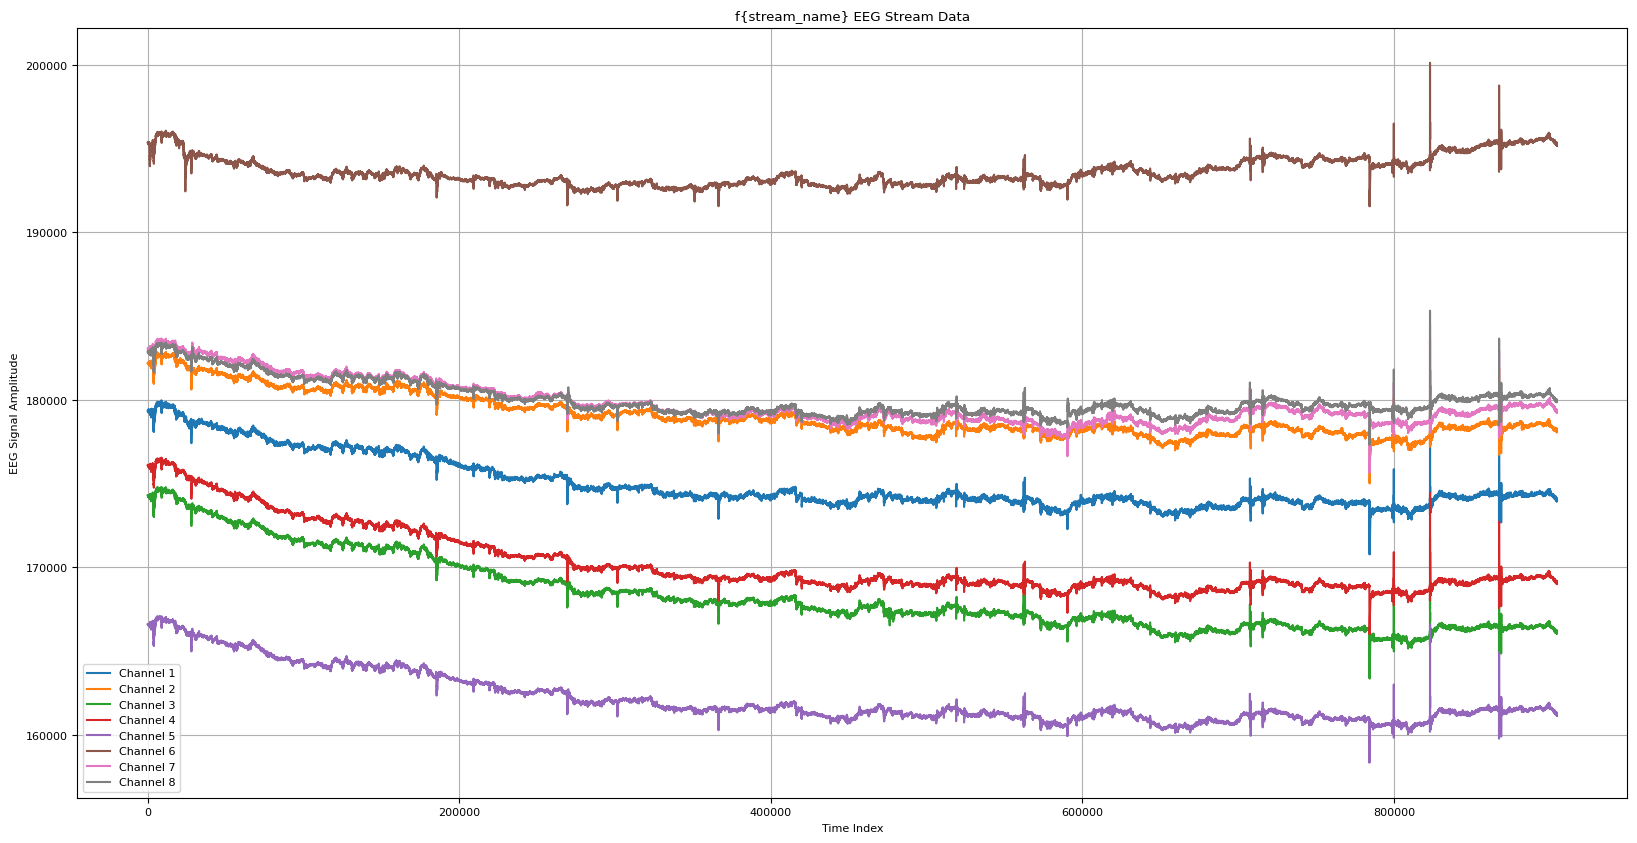

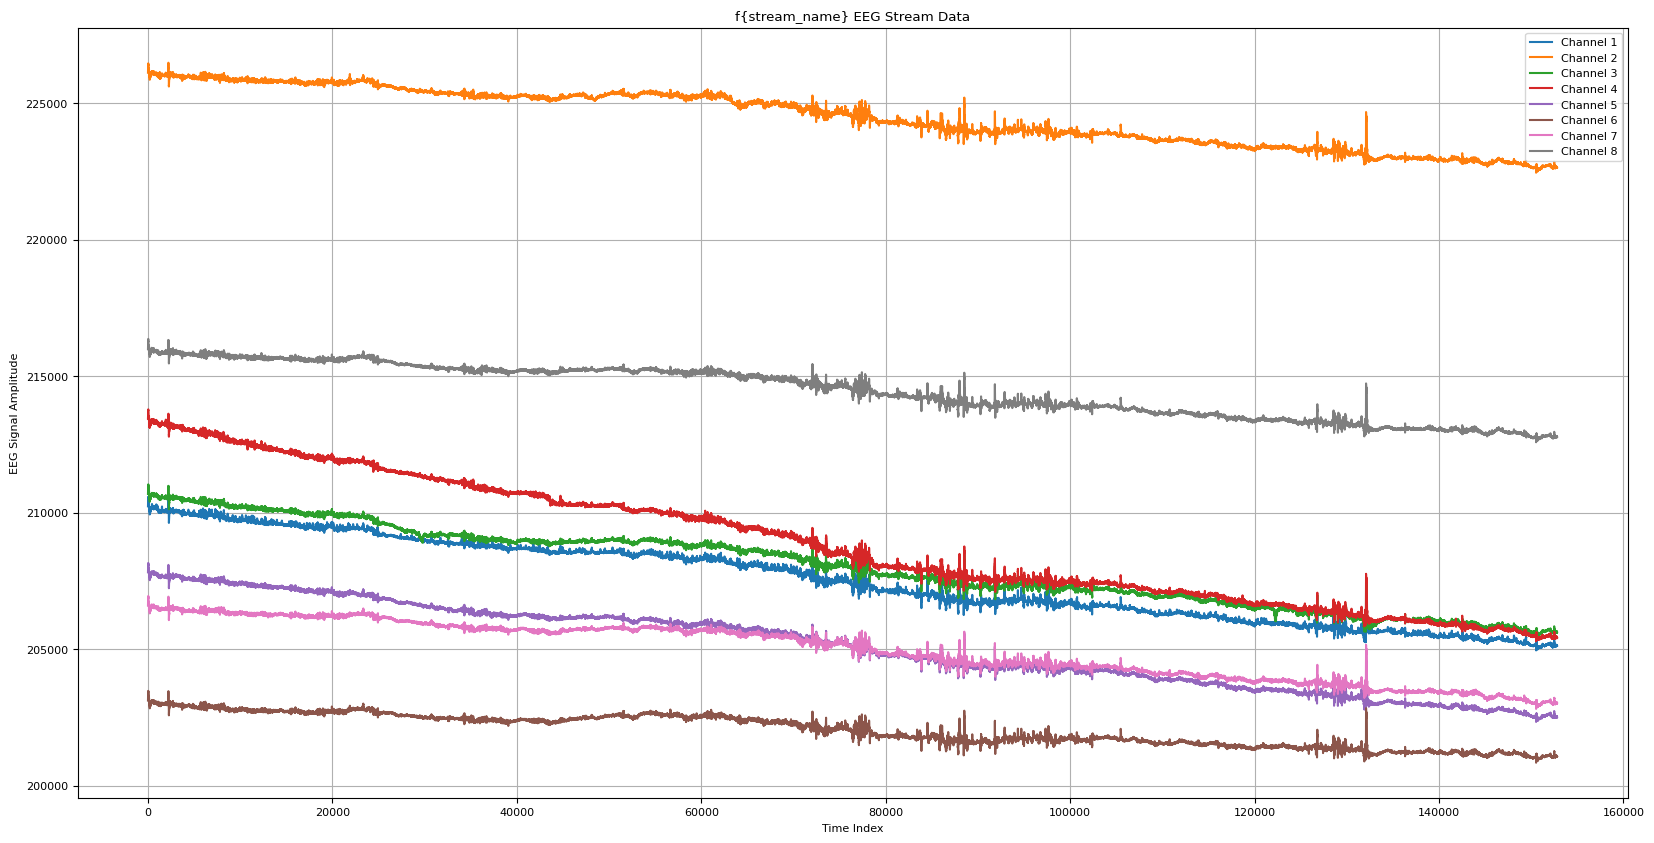

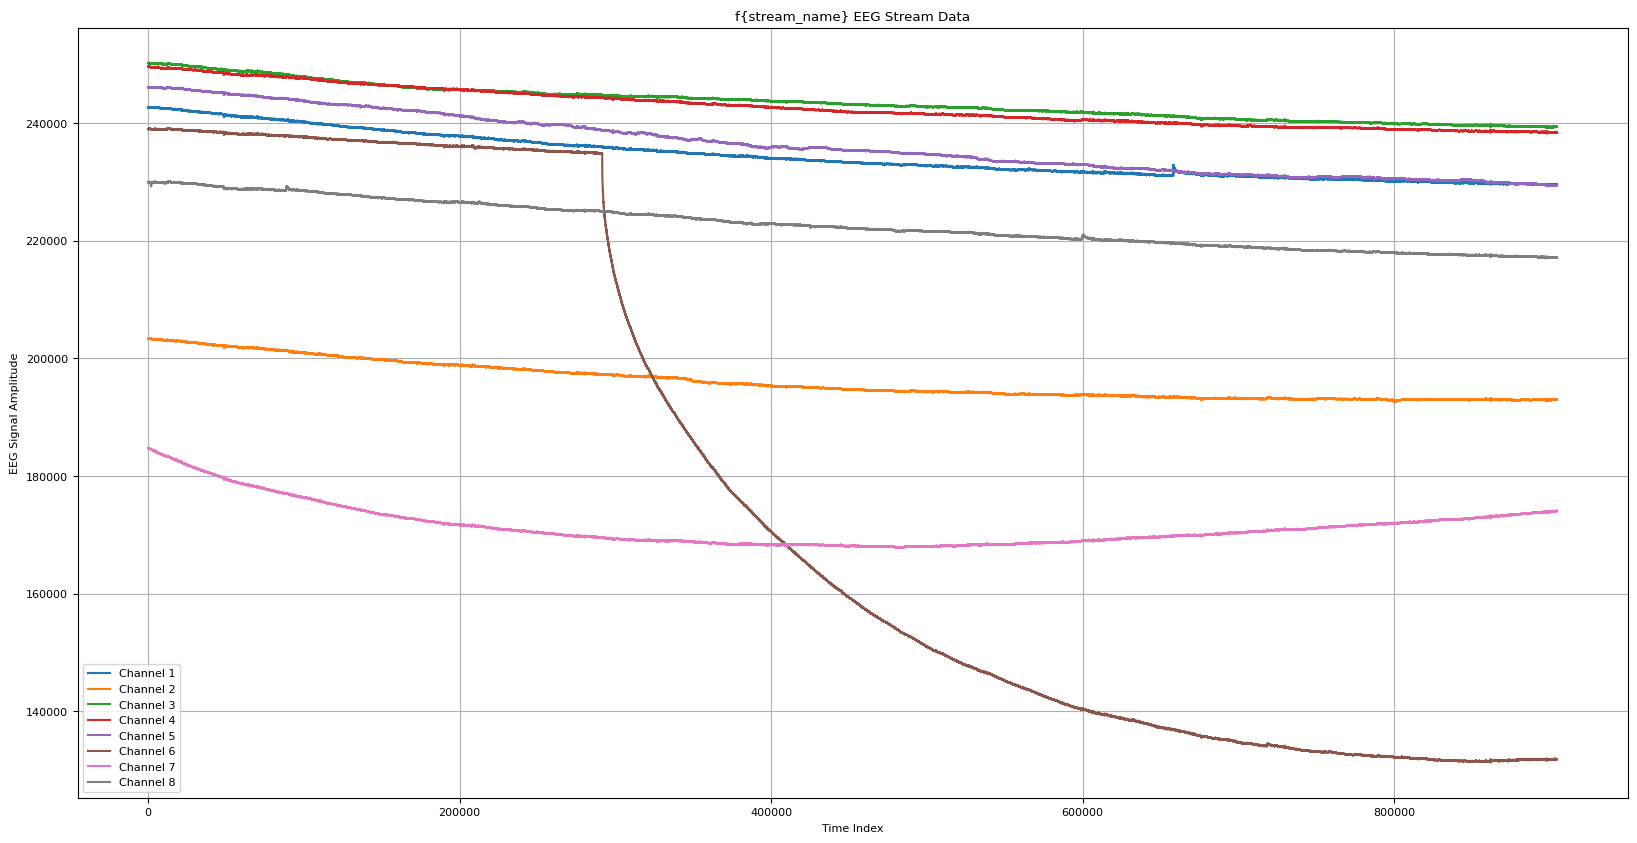

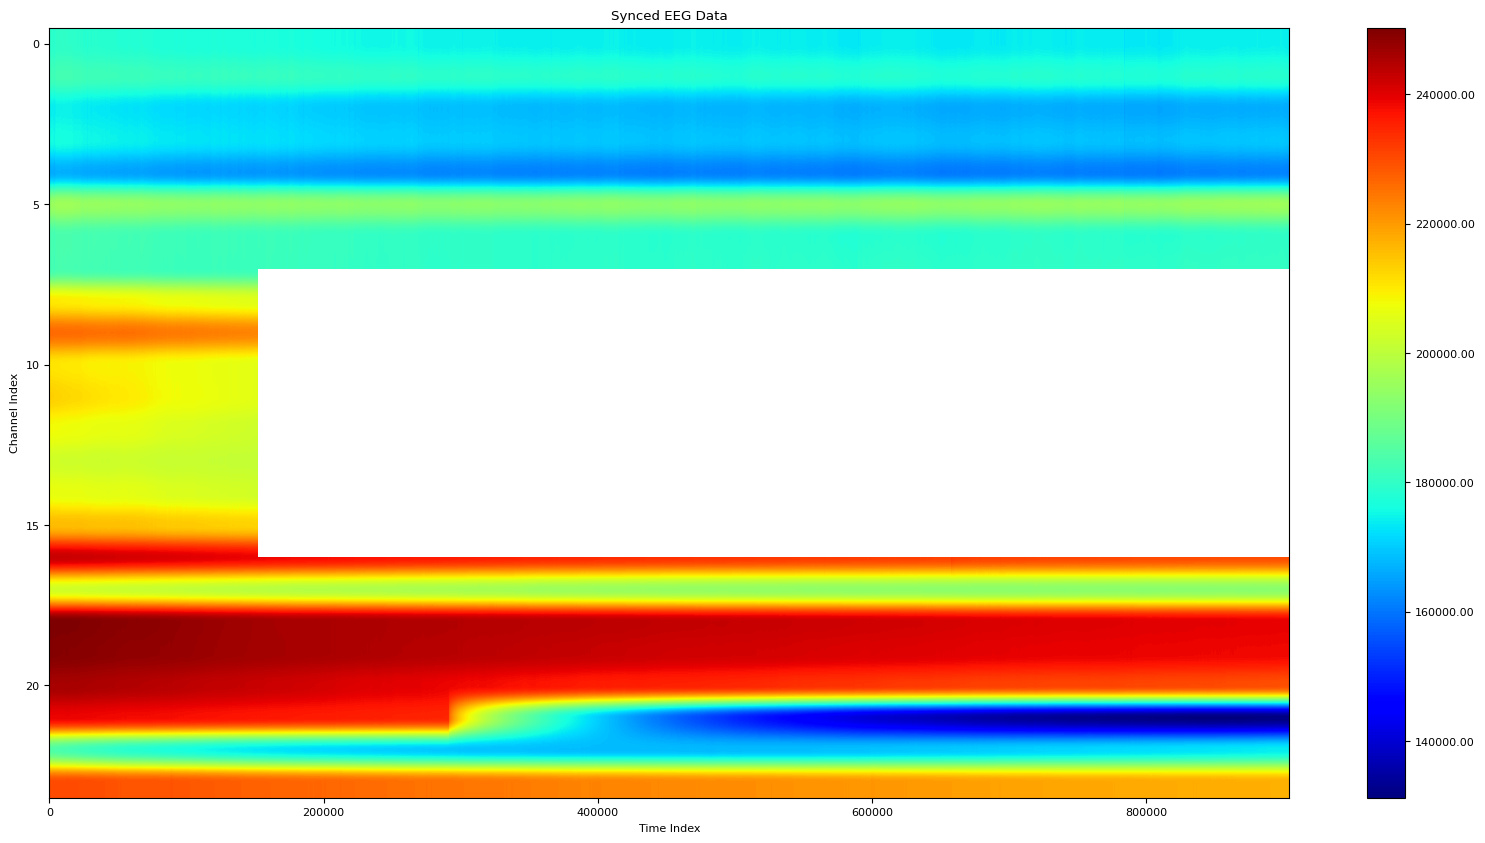

Min: 131222.078125
Max: 250303.421875
Mean: 196892.1730837323
Standard Deviation: 29780.84593398667


In [12]:
import scipy.io

# Disable scientific notation in NumPy globally
np.set_printoptions(suppress=True)

# find the max length of time_series in all EEG streams to establish dimensions for synced EEG streams
max_length = 0

for stream_name in ["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop"]:
    max_length = max(max_length, len(streams[stream_name]["time_series"]))

# Create an np array to hold the synced EEG data with dimensions (max_length, 3 * 8)
synced_EEG_data = np.full((max_length, 3 * 8), np.nan)

# Fill in the synced EEG data
for j, stream_name in enumerate(["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop"]):
    EEG_stream = streams[stream_name]
    
    eeg_stream_data = np.full((len(EEG_stream["time_series"]), 8), np.nan)
    for time_index, eeg_data in enumerate(EEG_stream["time_series"]):
        synced_EEG_data[time_index, j * 8:(j + 1) * 8] = eeg_data[0:8]
        eeg_stream_data[time_index, :] = eeg_data[0:8]
    
    # Visualize the EEG stream data
    time_indices = range(eeg_stream_data.shape[0])
    
    plt.figure(figsize=(20, 10))
    
    # Plot each channel as a separate line
    for channel_idx in range(eeg_stream_data.shape[1]):
        plt.plot(time_indices, eeg_stream_data[:, channel_idx], label=f'Channel {channel_idx+1}')

    plt.title("f{stream_name} EEG Stream Data")
    plt.xlabel("Time Index")
    plt.ylabel("EEG Signal Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Download the EEG data as an .mat file
    scipy.io.savemat(f'{stream_name}.mat', {f'{stream_name}': eeg_stream_data})

# Visualize the synced EEG data
plt.figure(figsize=(20, 10))
plt.imshow(synced_EEG_data.T, aspect='auto', cmap='jet')
plt.colorbar(format='%.2f')  # Ensures color bar does not use scientific notation
plt.title("Synced EEG Data")
plt.xlabel("Time Index")
plt.ylabel("Channel Index")
plt.show()

print("Min:", np.nanmin(synced_EEG_data))
print("Max:", np.nanmax(synced_EEG_data))
print("Mean:", np.nanmean(synced_EEG_data))
print("Standard Deviation:", np.nanstd(synced_EEG_data))

# Download the EEG data as an .mat file
scipy.io.savemat('task_cutoff_EEG_data_10.mat', {'task_cutoff_EEG_data_10': synced_EEG_data})